In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

from gensim.models import word2vec, KeyedVectors

In [63]:
periods = [('1950', '1959'), ('1960', '1969'), ('1970', '1979'), ('1980', '1989'), ('1990', '1999'), ('2000', '2009'), ('2010', '2021')]
wv_models = [(b, e, KeyedVectors.load('/media/sdb/p2v/pickles/decades/%s_to_%s/%dfeat_%dcontext_win_size' % (b, e, 100, 10))) for b, e in periods]
len(wv_models)

7

In [65]:
with open('/media/sdb/p2v/pickles/MAG_venue_info_df.pkl', 'rb') as df_file:
    MAG_venue_info_df = pd.compat.pickle_compat.load(df_file)

In [3]:
with open('/media/sdb/p2v/pickles/neighbor_semantic_change.pkl', 'rb') as fin:
    local_change = pd.compat.pickle_compat.load(fin)

In [5]:
local_change.shape

(24152, 15)

In [6]:
local_change.head()

,VID,semantic_change_1960s,accumulated_semantic_change_1960s,semantic_change_1970s,accumulated_semantic_change_1970s,semantic_change_1980s,accumulated_semantic_change_1980s,semantic_change_1990s,accumulated_semantic_change_1990s,semantic_change_2000s,accumulated_semantic_change_2000s,semantic_change_2010s,accumulated_semantic_change_2010s,venue_name,scopus_label
0,2.785285e+06,0.019514,0.019514,0.012496,0.032010,0.010597,0.042607,0.005943,0.048550,0.002106,0.050656,0.004989,0.055645,The Journal of Comparative Neurology,Neuroscience
2,2.756444e+09,0.022656,0.022656,0.025409,0.048065,0.014738,0.062802,0.023930,0.086732,0.042106,0.128838,0.123090,0.251928,Advances in internal medicine,NaN
3,1.709670e+08,0.034859,0.034859,0.035788,0.070647,0.022828,0.093475,0.018376,0.111850,0.012381,0.124232,0.008327,0.132559,American Journal of Epidemiology,Medicine
4,1.241662e+08,0.008383,0.008383,0.009423,0.017806,0.009184,0.026990,0.010620,0.037609,0.015446,0.053055,0.008831,0.061886,Quarterly Journal of Mechanics and Applied Mat...,Mathematics
5,2.764775e+09,0.003786,0.003786,0.004354,0.008140,0.007919,0.016058,0.005507,0.021565,0.004847,0.026412,0.003399,0.029811,Journal of the Geological Society of Japan,Earth and Planetary Sciences


In [61]:
local_change[local_change.venue_name.isin(['The Imaging Science Journal', 'Database'])]

,VID,semantic_change_1960s,accumulated_semantic_change_1960s,semantic_change_1970s,accumulated_semantic_change_1970s,semantic_change_1980s,accumulated_semantic_change_1980s,semantic_change_1990s,accumulated_semantic_change_1990s,semantic_change_2000s,accumulated_semantic_change_2000s,semantic_change_2010s,accumulated_semantic_change_2010s,venue_name,scopus_label
712,12054454.0,0.022983,0.022983,0.044134,0.067117,0.094843,0.161959,0.055363,0.217322,0.072437,0.289759,0.025429,0.315188,The Imaging Science Journal,Computer Science
7970,5986019.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003987,0.003987,0.296879,0.300866,0.015303,0.316169,Database,Computer Science


In [76]:
pd.DataFrame(wv_models[2][2].most_similar(12054454, topn=10), columns=['neighbor', 'sim']).merge(MAG_venue_info_df.reset_index()[['VenueID','OriginalVenue']], left_on='neighbor', right_on='VenueID', how='left')

,neighbor,sim,VenueID,OriginalVenue
0,2.047652e+08,0.495989,204765162,Physics in Technology
1,9.209410e+05,0.490446,920941,Color Research and Application
2,2.765071e+09,0.469507,2765071011,Smpte Journal
3,2.014417e+08,0.468734,201441698,Optik
4,1.280550e+08,0.466334,128054985,Production Engineer
5,9.552206e+07,0.465939,95522064,Medical Physics
6,1.346507e+08,0.465920,134650658,The Journal of The Institute of Image Informat...
7,1.409287e+08,0.463416,140928716,Precision Engineering-journal of The Internati...
8,6.408156e+07,0.461636,64081563,Solid State Technology
9,5.845783e+07,0.458022,58457832,Gold Bulletin


In [77]:
pd.DataFrame(wv_models[3][2].most_similar(12054454, topn=10), columns=['neighbor', 'sim']).merge(MAG_venue_info_df.reset_index()[['VenueID','OriginalVenue']], left_on='neighbor', right_on='VenueID', how='left')

,neighbor,sim,VenueID,OriginalVenue
0,2.014417e+08,0.596802,201441698,Optik
1,2.764894e+09,0.585958,2764894355,Philips technical review
2,1.027282e+08,0.582174,102728161,Optics and Lasers in Engineering
3,2.764842e+09,0.579101,2764841839,British Journal of Non-Destructive Testing
4,2.764944e+09,0.561510,2764944069,Journal of the Spectroscopical Society of Japan
5,2.765035e+09,0.549871,2765034920,GEC journal of research
6,1.755434e+08,0.547880,175543413,Optical Engineering
7,2.034142e+08,0.536007,203414176,Materials evaluation
8,2.772852e+07,0.533951,27728525,Journal of Machine Vision and Applications
9,1.588973e+08,0.530365,158897336,Nuklearmedizin-nuclear Medicine


In [78]:
pd.DataFrame(wv_models[4][2].most_similar(12054454, topn=10), columns=['neighbor', 'sim']).merge(MAG_venue_info_df.reset_index()[['VenueID','OriginalVenue']], left_on='neighbor', right_on='VenueID', how='left')

,neighbor,sim,VenueID,OriginalVenue
0,1.249203e+07,0.625521,12492028,Studies in Conservation
1,6.919626e+07,0.618431,69196262,Journal of Imaging Science and Technology
2,2.764953e+09,0.599813,2764953309,The conservator
3,2.764947e+09,0.595303,2764947233,Journal of The Society of Photographic Science...
4,1.012880e+08,0.577123,101288035,Pure and Applied Optics: Journal of The Europe...
5,1.165869e+09,0.573468,1165869400,color imaging conference
6,2.911401e+07,0.553805,29114012,Restaurator-international Journal for The Pres...
7,2.764739e+09,0.553009,2764738506,AICCM bulletin
8,1.289369e+08,0.548220,128936867,Journal of Optics
9,9.209410e+05,0.533995,920941,Color Research and Application


In [79]:
pd.DataFrame(wv_models[5][2].most_similar(12054454, topn=10), columns=['neighbor', 'sim']).merge(MAG_venue_info_df.reset_index()[['VenueID','OriginalVenue']], left_on='neighbor', right_on='VenueID', how='left')

,neighbor,sim,VenueID,OriginalVenue
0,1.518206e+08,0.623292,151820558,Pattern Recognition Letters
1,6.919626e+07,0.614948,69196262,Journal of Imaging Science and Technology
2,2.754707e+09,0.605998,2754706624,international conference on digital image proc...
3,2.764822e+09,0.604816,2764822136,Image Processing and Communications
4,2.765013e+09,0.592304,2765012913,Journal of Electrical and Electronic Engineering
5,2.760193e+09,0.591187,2760193176,international symposium on mathematical morpho...
6,1.755434e+08,0.587056,175543413,Optical Engineering
7,4.145660e+05,0.583639,414566,Pattern Recognition
8,1.133222e+09,0.581058,1133222229,computational color imaging workshop
9,1.585111e+08,0.574504,158511090,Journal of Electronic Imaging


In [80]:
pd.DataFrame(wv_models[6][2].most_similar(12054454, topn=10), columns=['neighbor', 'sim']).merge(MAG_venue_info_df.reset_index()[['VenueID','OriginalVenue']], left_on='neighbor', right_on='VenueID', how='left')

,neighbor,sim,VenueID,OriginalVenue
0,8.321536e+07,0.810934,83215360,Iet Image Processing
1,1.054249e+08,0.772832,105424869,Journal of Visual Communication and Image Repr...
2,1.569045e+08,0.768069,156904493,"Signal, Image and Video Processing"
3,1.102067e+08,0.743355,110206669,Multimedia Tools and Applications
4,1.537673e+08,0.741358,153767265,Eurasip Journal on Image and Video Processing
5,1.153046e+08,0.723884,115304631,IEEE Transactions on Image Processing
6,3.809073e+07,0.721734,38090728,Signal Processing-image Communication
7,1.585111e+08,0.718096,158511090,Journal of Electronic Imaging
8,2.764783e+09,0.707811,2764782550,ICTACT Journal on Image and Video Processing
9,2.480669e+09,0.704138,2480669183,"International Journal of Image, Graphics and S..."


<AxesSubplot: >

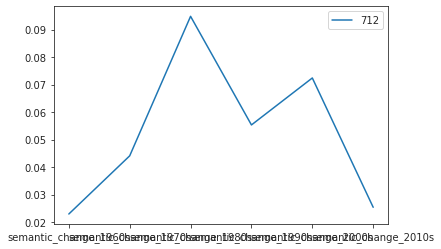

In [85]:
local_change[local_change.venue_name == 'The Imaging Science Journal'][['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s']].T.plot()

In [75]:
local_change.sort_values(by=['accumulated_semantic_change_2010s'], ascending=False)[90:100]

,VID,semantic_change_1960s,accumulated_semantic_change_1960s,semantic_change_1970s,accumulated_semantic_change_1970s,semantic_change_1980s,accumulated_semantic_change_1980s,semantic_change_1990s,accumulated_semantic_change_1990s,semantic_change_2000s,accumulated_semantic_change_2000s,semantic_change_2010s,accumulated_semantic_change_2010s,venue_name,scopus_label
10237,2.754943e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025391,0.025391,0.236761,0.262152,Alaska medicine,NaN
23920,1.351026e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.261830,0.261830,Synfacts,NaN
941,2.755368e+09,0.006645,0.006645,0.010709,0.017355,0.022164,0.039519,0.019493,0.059011,0.070295,0.129307,0.131129,0.260436,Journal of the Medical Association of Georgia,NaN
12807,2.755711e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.203137,0.203137,0.057284,0.260421,Revista de enfermería,NaN
319,2.069152e+08,0.007289,0.007289,0.018629,0.025918,0.085738,0.111656,0.092993,0.204648,0.032018,0.236666,0.023082,0.259748,Aircraft Engineering and Aerospace Technology,Engineering
15383,2.764707e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258845,0.258845,International journal of sciences,NaN
13120,2.079683e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.231814,0.231814,0.026542,0.258356,International Journal on Disability and Human ...,Medicine
18785,2.764614e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.257927,0.257927,International Journal of Medical and Health Sc...,NaN
2188,1.260132e+08,NaN,NaN,0.034709,0.034709,0.030022,0.064730,0.053674,0.118404,0.059240,0.177643,0.077743,0.255386,Systems Research and Behavioral Science,"Business, Management and Accounting"
2506,1.179645e+09,NaN,NaN,0.034270,0.034270,0.086399,0.120669,0.082370,0.203039,0.028052,0.231091,0.024157,0.255249,biomedical engineering,NaN


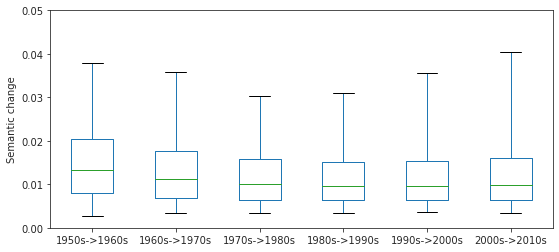

In [44]:
def plot_change_distribution(save=False):
    """"""
    ax = local_change.boxplot(column=['semantic_change_1960s', 'semantic_change_1970s', 'semantic_change_1980s', 'semantic_change_1990s', 'semantic_change_2000s', 'semantic_change_2010s'], 
                              whis=(5,95), grid=False, showfliers=False, figsize=(9, 4))
    ax.set(ylim=[0,0.05], xticklabels=['1950s->1960s', '1960s->1970s', '1970s->1980s', '1980s->1990s', '1990s->2000s', '2000s->2010s'], ylabel='Semantic change')
    if save:
        plt.savefig('../figs/semantic_change_local_dist.pdf', bbox_inches='tight')

plot_change_distribution(True)